In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit, random

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

import functools

import tensorflow_probability.substrates.jax as tfp
tfpd = tfp.distributions
tfpb = tfp.bijectors

from jaxns import ExactNestedSampler
from jaxns import TerminationCondition
# from jaxns import analytic_log_evidence
from jaxns import Prior, Model

/opt/homebrew/anaconda3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
INFO[2023-06-22 15:14:20,158]: Remote TPU is not linked into jax; skipping remote TPU.
INFO[2023-06-22 15:14:20,158]: Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO[2023-06-22 15:14:20,159]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-22 15:14:20,159]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-22 15:14:20,159]: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO[2023-06-22 15:14:20,159]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:ena

In [6]:
def get_kernel(kernel_type, kernel_params):
    if kernel_type == "QPO_plus_RN":
        kernel = kernels.quasisep.Exp(
            scale=1 / kernel_params["crn"], sigma=(kernel_params["arn"]) ** 0.5
        ) + kernels.quasisep.Celerite(
            a=kernel_params["aqpo"],
            b=0.0,
            c=kernel_params["cqpo"],
            d=2 * jnp.pi * kernel_params["freq"],
        )
        return kernel
    elif kernel_type == "RN":
        kernel = kernels.quasisep.Exp(
            scale=1 / kernel_params["crn"], sigma=(kernel_params["arn"]) ** 0.5
        )
        return kernel

def get_mean(mean_type, mean_params):
    if mean_type == "gaussian":
        mean = functools.partial(_gaussian, mean_params=mean_params)
    elif mean_type == "exponential":
        mean = functools.partial(_exponential, mean_params=mean_params)
    elif mean_type == "constant":
        mean = functools.partial(_constant, mean_params=mean_params)
    elif mean_type == "skew_gaussian":
        mean = functools.partial(_skew_gaussian, mean_params=mean_params)
    elif mean_type == "skew_exponential":
        mean = functools.partial(_skew_exponential, mean_params=mean_params)
    elif mean_type == "fred":
        mean = functools.partial(_fred, mean_params=mean_params)
    return mean

def _gaussian(t, mean_params):
    A = jnp.atleast_1d(mean_params["A"])[:,jnp.newaxis]
    t0 = jnp.atleast_1d(mean_params["t0"])[:,jnp.newaxis]
    sig = jnp.atleast_1d(mean_params["sig"])[:,jnp.newaxis]

    return jnp.sum (A * jnp.exp(
        -((t - t0) ** 2) / (2 * (sig ** 2))
    )
    , axis=0)

def _exponential(t, mean_params):
    A = jnp.atleast_1d(mean_params["A"])[:,jnp.newaxis]
    t0 = jnp.atleast_1d(mean_params["t0"])[:,jnp.newaxis]
    sig = jnp.atleast_1d(mean_params["sig"])[:,jnp.newaxis]

    return jnp.sum (A * jnp.exp(
        -jnp.abs(t - t0) / (2 * (sig ** 2))
    )
    , axis=0)

def _constant(t, mean_params):
    return mean_params["A"] * jnp.ones_like(t)

def _skew_gaussian(t, mean_params):
    return mean_params["A"] * jnp.where(
        t > mean_params["t0"],
        jnp.exp(-((t - mean_params["t0"]) ** 2) / (2 * (mean_params["sig2"] ** 2))),
        jnp.exp(-((t - mean_params["t0"]) ** 2) / (2 * (mean_params["sig1"] ** 2))),
    )

def _skew_exponential(t, mean_params):
    return mean_params["A"] * jnp.where(
        t > mean_params["t0"],
        jnp.exp(-(t - mean_params["t0"]) / mean_params["sig2"]),
        jnp.exp((t - mean_params["t0"]) / mean_params["sig1"]),
    )

def _fred(t, mean_params):
    return mean_params["A"] * jnp.exp(-mean_params["phi"] * ((t + mean_params["delta"])/mean_params["t0"] + 
                                                             mean_params["t0"]/(t + mean_params["delta"])))*jnp.exp(2*mean_params["phi"])

def get_kernel_params(kernel_type):
    if kernel_type == "RN":
        return ['arn','crn']
    elif kernel_type == "QPO_plus_RN":
        return ['arn','crn', 'aqpo', 'cqpo', 'freq']

def get_mean_params(mean_type):
    if (mean_type == "gaussian") or (mean_type == "exponential"):
        return ['A', 't0', 'sig']
    elif (mean_type == "constant"):
        return ['A']
    elif (mean_type == "skew_gaussian") or (mean_type == "skew_exponential"):
        return ['A', 't0', 'sig1', 'sig2']
    elif (mean_type == "fred"):
        return ['A', 't0', 'delta', 'phi']
    

def get_gp_params(kernel_type, mean_type):
    kernel_params = get_kernel_params(kernel_type)
    mean_params = get_mean_params(mean_type)
    kernel_params.extend(mean_params)
    return kernel_params

def get_kernel_priors(kernel_type, **kwargs):
    if kernel_type == "RN":
        return {"arn" : tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), 
                "crn": tfpd.Uniform(jnp.log(1 / kwargs["T"]), jnp.log(kwargs["f"])), }
    elif kernel_type == "QPO_plus_RN":
        return {"arn" : tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), 
                "crn": tfpd.Uniform(jnp.log(1 / kwargs["T"]), jnp.log(kwargs["f"])),
                "aqpo" : tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]),
                "cqpo": tfpd.Uniform(1 / 10 / kwargs["T"], jnp.log(kwargs["f"])),
                "freq":tfpd.Uniform(2 / kwargs["T"], kwargs["f"] / 2),}

from jaxns.types import float_type
from jaxns.special_priors import ForcedIdentifiability

def get_mean_priors(mean_type, peak_prior_type, **kwargs):
    dict = {}
    dict["A"] = tfpd.Uniform(low=0.1 * kwargs["span"] * jnp.ones(kwargs["n"]),
                            high=2 * kwargs["span"] * jnp.ones(kwargs["n"]))
    
    if peak_prior_type == "uniform":
        t0 = ForcedIdentifiability(n = kwargs["n"], low = kwargs["Times"][0]-0.1*kwargs["T"], 
                                         high = kwargs["Times"][-1]+0.1*kwargs["T"], name='t0')
        dict["t0"] = t0
    elif peak_prior_type == "beta":
        # would not work
        t0 = []
        scale_bij = tfp.bijectors.Scale(scale=kwargs["Times"][-1]+0.1*kwargs["T"] - kwargs["Times"][0]-0.1*kwargs["T"])
        shift_bij = tfp.bijectors.Shift(shift=kwargs["Times"][0]-0.1*kwargs["T"])
        for i in range(kwargs["n"]):
            underlying_beta = tfpd.Beta(
                concentration0=jnp.asarray(1., float_type),
                concentration1=jnp.asarray(kwargs["n"] - i, float_type)
            )
            t = yield Prior(shift_bij(scale_bij(underlying_beta)), name=f"t{i}")
            # t = Prior(shift_bij(scale_bij(underlying_beta)), name=f"t{i}")
            # t = shift_bij(scale_bij(underlying_beta)) Cannot use this as the below operation -t is not supported
            # even after prior shift ... , yield is doing it
            scale_bij = tfp.bijectors.Scale(scale=kwargs["Times"][-1]+0.1*kwargs["T"] - t)
            shift_bij = tfp.bijectors.Shift(shift=t)
            t0.append(t)
        t0 = jnp.stack(t0)
        dict["t0"] = t0

    if (mean_type == "gaussian") or (mean_type == "exponential"):
        dict["sig"] = tfpd.Uniform(0.5 * 1 / kwargs["f"]*jnp.ones(kwargs["n"]) , 2 * kwargs["T"]*jnp.ones(kwargs["n"]))
    elif (mean_type == "constant"):
        return {"A": tfpd.Uniform(0, 2)}
    elif (mean_type == "skew_gaussian") or (mean_type == "skew_exponential"):
        dict["sig1"] = tfpd.Uniform(0.5 * 1 / kwargs["f"]*jnp.ones(kwargs["n"]) , 2 * kwargs["T"]*jnp.ones(kwargs["n"]))
        dict["sig2"] = tfpd.Uniform(0.5 * 1 / kwargs["f"]*jnp.ones(kwargs["n"]) , 2 * kwargs["T"]*jnp.ones(kwargs["n"]))
    elif (mean_type == "fred"):
        dict["delta"] = tfpd.Uniform(2*jnp.exp(-2)*jnp.ones(kwargs["n"]), 2*jnp.exp(4)*jnp.ones(kwargs["n"]))
        dict["phi"] = tfpd.Uniform(0*jnp.ones(kwargs["n"]), kwargs["Times"][-1]/2*jnp.ones(kwargs["n"]))
    return dict

def get_prior(params_list, kernel_type, mean_type, peak_prior_type,  **kwargs):
    kwargs["T"] = kwargs["Times"][-1] - kwargs["Times"][0]  # Total time
    kwargs["f"] = 1 / (kwargs["Times"][1] - kwargs["Times"][0])  # Sampling frequency
    kwargs["min"] = jnp.min(kwargs["counts"])
    kwargs["max"] = jnp.max(kwargs["counts"])
    kwargs["span"] = kwargs["max"] - kwargs["min"]
    dict = {}
    dict.update(get_kernel_priors(kernel_type,**kwargs))
    print("kernel_dict",get_kernel_priors(kernel_type,**kwargs))
    print("mean_dict",get_mean_priors(mean_type, peak_prior_type,**kwargs))
    dict.update(get_mean_priors(mean_type, peak_prior_type,**kwargs))
    def prior_model():
        prior_list = []
        for i in params_list:
            if isinstance(dict[i], tfpd.Distribution):
                parameter = yield Prior (dict[i], name = i)
            else:
                parameter = yield dict[i]
            prior_list.append(parameter)
        return tuple(prior_list)
    return prior_model

def get_likelihood(params_list, kernel_type, mean_type, **kwargs):
    def likelihood_model(*args):    
        dict = {}
        for i, params in enumerate(params_list):
            dict[params] = args[i]
        kernel = get_kernel(kernel_type=kernel_type, kernel_params=dict)
        mean = get_mean(mean_type=mean_type, mean_params=dict)
        gp = GaussianProcess(kernel, kwargs["Times"], mean_value=mean(kwargs["Times"]))
        return gp.log_probability(kwargs["counts"])
    return likelihood_model

In [7]:
import tinygp

# MAKING THE DATA
Times = np.linspace(0,1,256)

kernel = kernel = kernels.quasisep.Exp(
                scale = 1/jnp.exp(1.0), sigma = (jnp.exp(1.0))**0.5) + kernels.quasisep.Celerite(
                a = jnp.exp(-2), b = 0.0, c = jnp.exp(1), d = 2*jnp.pi*20)

def gaussian(t, mean_params):
    return mean_params["A"] * jnp.exp(-((t - mean_params["t0"])**2)/(2*(mean_params["sig"]**2)))

mean = get_mean(mean_type = "gaussian", 
                    mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), "sig" : jnp.array([0.2, 0.1]) })

hqpogp = tinygp.GaussianProcess( kernel, Times, mean_value = mean(Times) , diag = 0.01)
counts = hqpogp.sample(jax.random.PRNGKey(101))
lightcurve = Lightcurve(Times, counts)

INFO[2023-06-22 15:15:40,388]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-06-22 15:15:40,388]: Checking if light curve is sorted.
INFO[2023-06-22 15:15:40,388]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


In [8]:
params_list = get_gp_params(kernel_type = "QPO_plus_RN", mean_type = "gaussian")
prior_model = get_prior(params_list, kernel_type = "QPO_plus_RN", mean_type = "gaussian", peak_prior_type = "uniform", Times = Times, counts = counts, n = 2)
likelihood_model = get_likelihood(params_list, kernel_type = "QPO_plus_RN", mean_type = "gaussian", Times = Times, counts = counts, n = 2)

model = Model(prior_model, likelihood_model)
model.sanity_check(random.PRNGKey(10), S=100)

Exact_ns = ExactNestedSampler(model, num_live_points=500, max_samples=1e4)
Termination_reason, State = Exact_ns(
            random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4)
        )
Results = Exact_ns.to_results(State, Termination_reason)

kernel_dict {'arn': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float64>, 'crn': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float64>, 'aqpo': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float64>, 'cqpo': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float64>, 'freq': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float64>}
mean_dict {'A': <tfp.distributions.Uniform 'Uniform' batch_shape=[2] event_shape=[] dtype=float64>, 't0': t0	(2,) -> (2,) float64, 'sig': <tfp.distributions.Uniform 'Uniform' batch_shape=[2] event_shape=[] dtype=float64>}


INFO[2023-06-22 15:15:42,701]: Sanity check...
INFO[2023-06-22 15:15:43,033]: Sanity check passed


--------
Termination Conditions:
Reached max samples
Small remaining evidence
--------
# likelihood evals: 1429142
# samples: 10000
# slices: 559316.0
# slices / acceptance: 67.0
# likelihood evals / sample: 142.9
# likelihood evals / slice: 2.5
--------
logZ=-82.44 +- 0.16
H=82.0
ESS=2461
--------
A[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A[0]: 4.4 +- 2.4 | 1.1 / 4.8 / 7.3 | 4.8 | 4.8
A[1]: 2.8 +- 1.2 | 1.2 / 2.7 / 4.3 | 1.0 | 1.0
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: 1.6 +- 1.7 | 0.8 / 1.1 / 2.3 | 1.0 | 1.0
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 9.9 +- 2.4 | 7.8 / 10.0 / 12.7 | 8.3 | 8.3
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 1.4 +- 1.6 | 0.1 / 0.4 / 3.9 | 0.3 | 0.3
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 1.12 +- 0.74 | 0.71 / 0.99 / 1.35 | 1.3 | 1.3
----

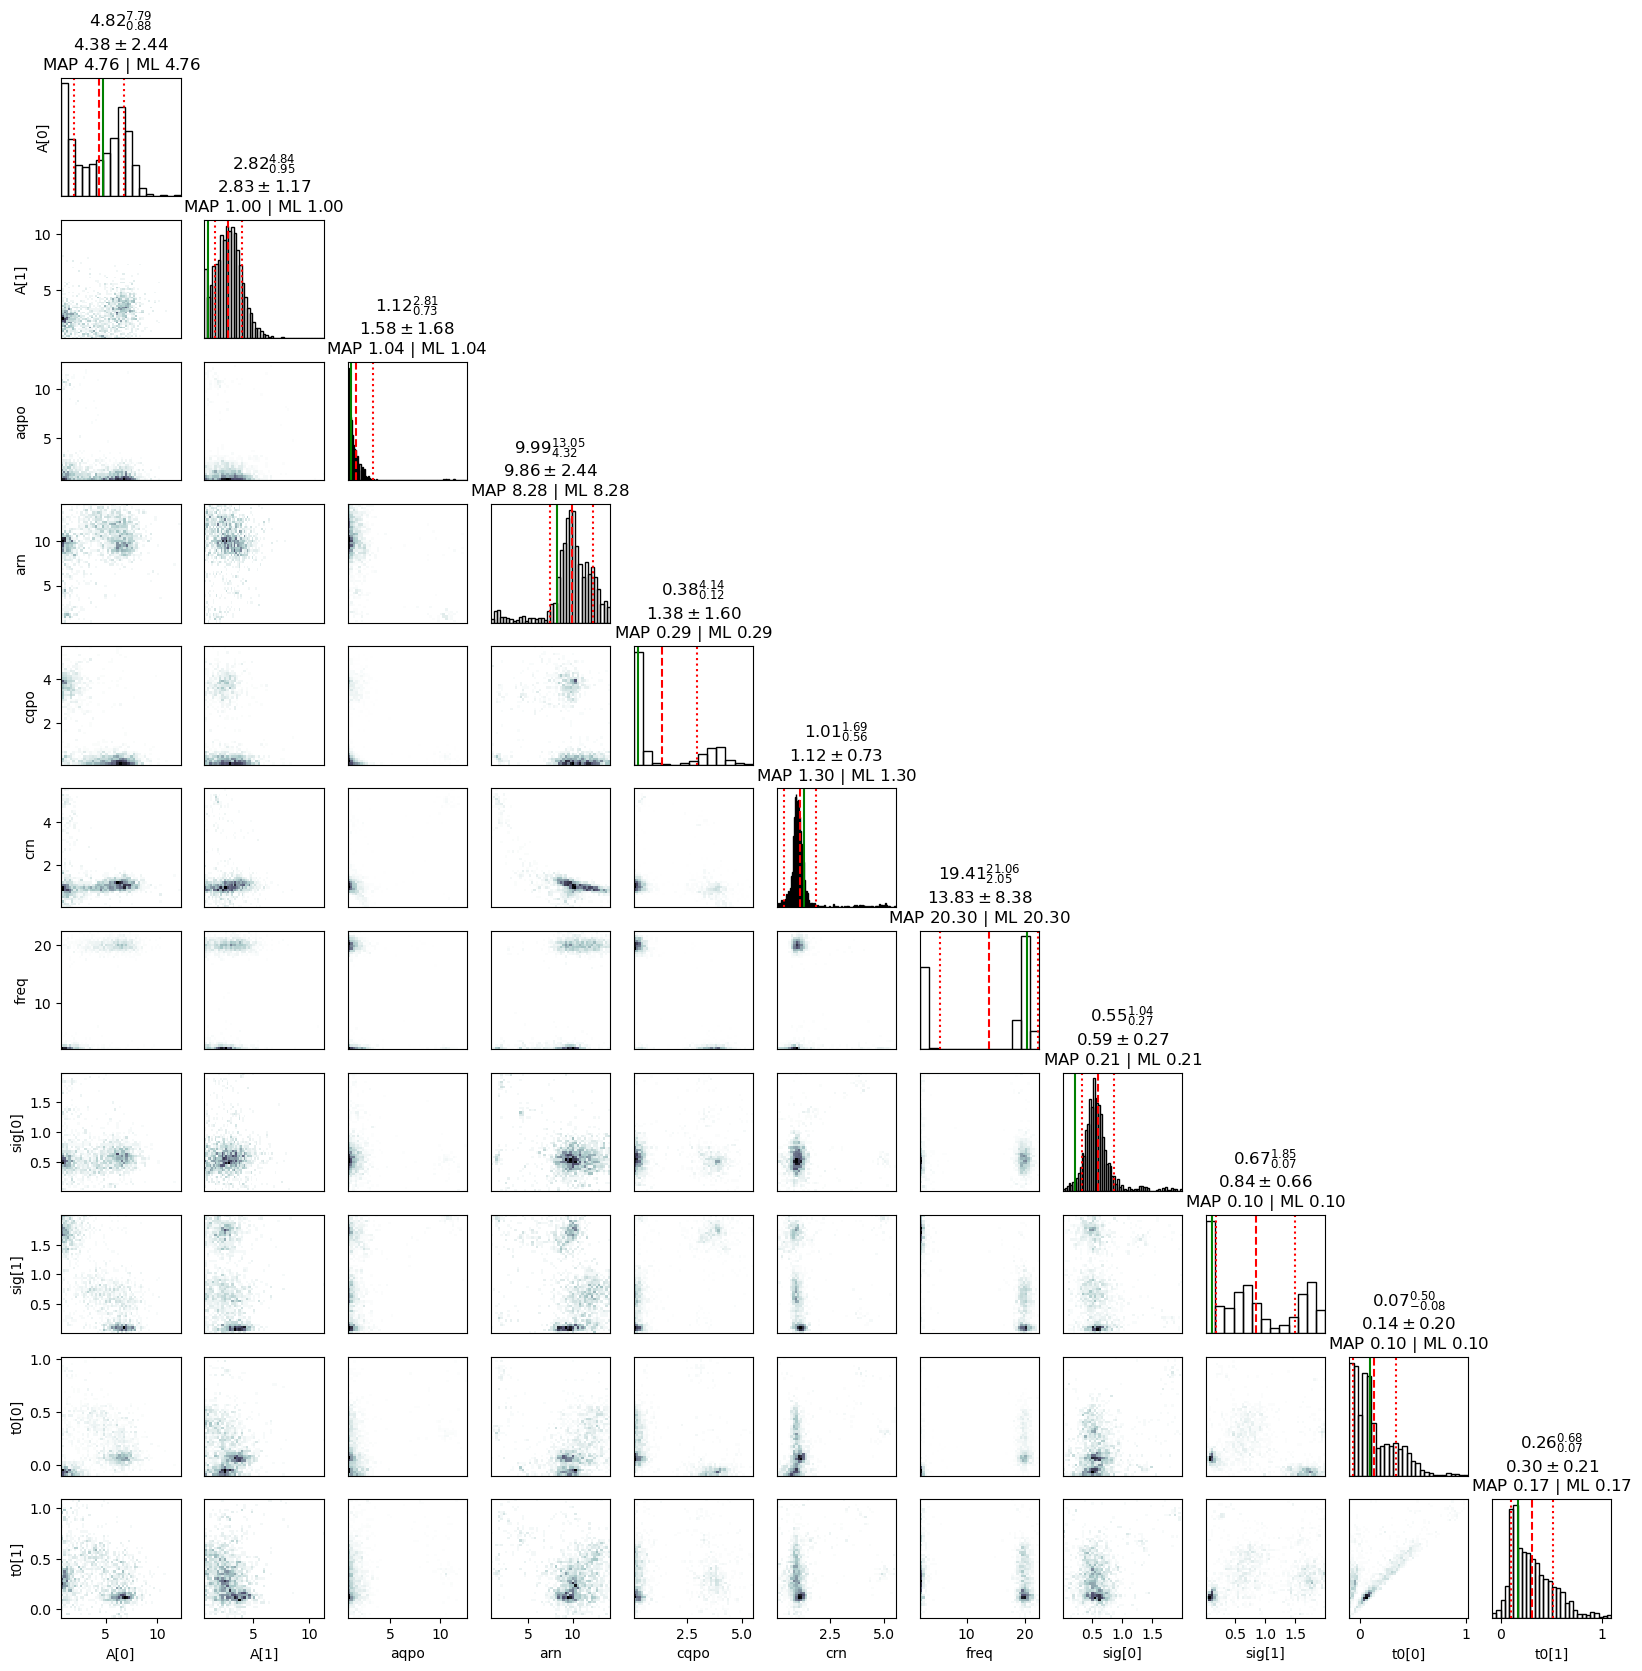

WARNING[2023-06-22 15:17:05,295]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


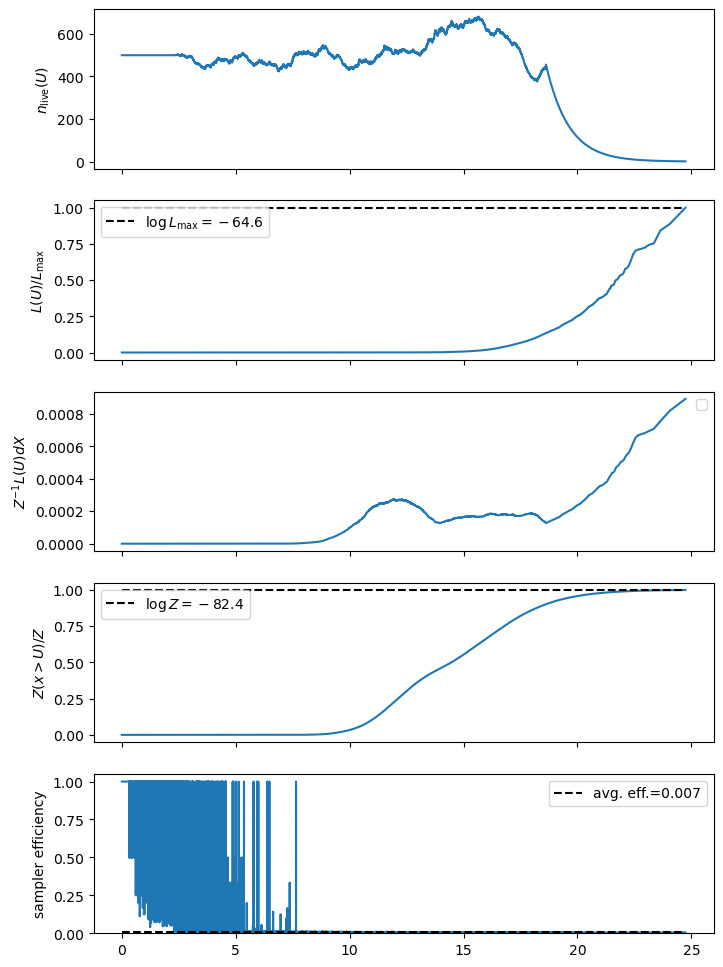

In [9]:
Exact_ns.summary(Results)
Exact_ns.plot_cornerplot(Results)
Exact_ns.plot_diagnostics(Results)

In [62]:
a = tfpd.Uniform(2*jnp.exp(-2), 2*jnp.exp(4))
if isinstance(a, tfpd.Distribution):
    print("hi1")

hi1
